In [1]:
import sys
sys.path.append("..")

In [2]:
from functools import partial
import time
from datetime import timedelta

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample, PyroParam
import pyro.infer.autoguide.initialization as ag_init

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import tyxe
pyro.set_rng_seed(42)

DEVICE = "cuda:0"

/Home/siv31/tak011/.conda/envs/master/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
x1 = torch.rand(5, 1) * 10.0 - 16.2
x2 = torch.rand(5, 1) * 10.4 + 3.2
x = torch.cat([x1, x2])
sigma = 0.05
noise = torch.normal(mean=torch.full_like(x, 0.), std=sigma)
y = 0.01*x + x.mul(0.2).add(-0.2).sin().mul(0.2) + noise

x_test = torch.linspace(-30, 30, 401).unsqueeze(-1)

y_test = 0.01*x_test + x_test.mul(0.2).add(-0.2).sin().mul(0.2)

In [47]:
x.shape, y.shape

(torch.Size([10, 1]), torch.Size([10, 1]))

In [48]:
dataset = data.TensorDataset(x, y)
loader = data.DataLoader(dataset, batch_size=len(x))

In [49]:
x1, y1 = next(iter(loader))

(-1.5, 1.5)

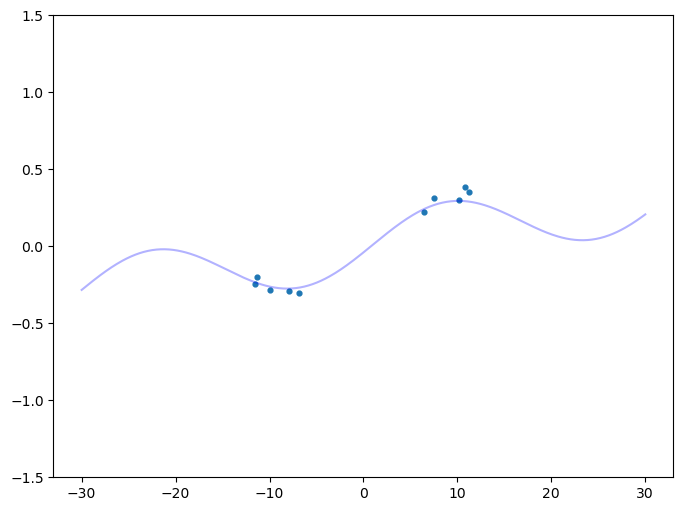

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)
plt.ylim(-1.5, 1.5)

In [51]:
net = nn.Sequential(nn.Linear(1, 128), nn.ReLU(), nn.Linear(128, 1)).to(DEVICE)
x, y = x.to(DEVICE), y.to(DEVICE)
optim = torch.optim.Adam(net.parameters(), 1e-4)
for _ in range(20000):
    optim.zero_grad()
    net(x).sub(y).pow(2).mean().backward()
    optim.step()

(-1.5, 1.5)

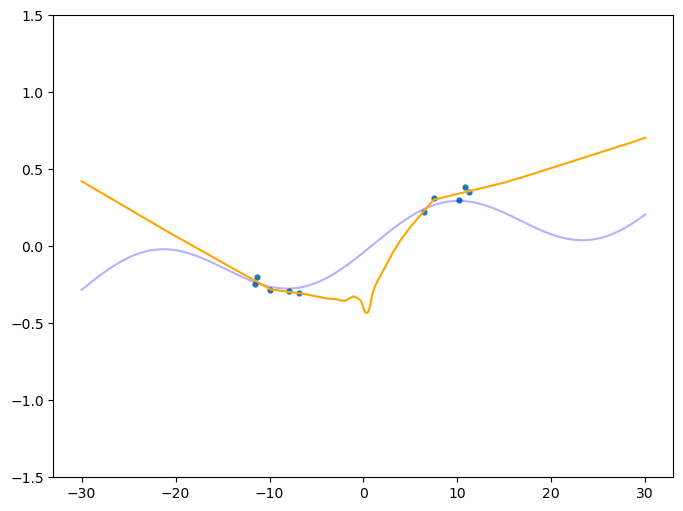

In [52]:
preds = net(x_test.to(DEVICE)).detach().cpu()
x, y = x.cpu(), y.cpu()

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)
plt.plot(x_test, preds, color="orange")
plt.ylim(-1.5, 1.5)


In [53]:
net = nn.Sequential(nn.Linear(1, 128), nn.ReLU(), nn.Linear(128, 1)).to(DEVICE)
net

Sequential(
  (0): Linear(in_features=1, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=1, bias=True)
)

In [54]:
prior_dist = dist.Normal(torch.tensor(0., device=DEVICE), torch.tensor(1., device=DEVICE))

prior = tyxe.priors.IIDPrior(prior_dist)

In [55]:
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=torch.tensor(0.01, device=DEVICE))

In [56]:
def init_fn (*args, **kwargs):
            return ag_init.init_to_median(*args, **kwargs).to(DEVICE) 

guide_builder = partial(tyxe.guides.AutoNormal, init_loc_fn=init_fn, init_scale=0.01)

In [57]:
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder)

In [58]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})

start = time.time()
elbos = []
def callback(bnn, i, e):
    if i % 500 == 0:
        print("[{}] | epoch: {} | elbo: {}".format(timedelta(seconds=time.time() - start), i, e))
    elbos.append(e)

bnn.fit(loader, optim, 20000, callback, device=DEVICE)
print("finished: ", timedelta(seconds=time.time() - start))

[0:00:00.025873] | epoch: 0 | elbo: 15522632.0
[0:00:11.855868] | epoch: 500 | elbo: 12261.83984375
[0:00:23.874590] | epoch: 1000 | elbo: 4884.7060546875
[0:00:36.168377] | epoch: 1500 | elbo: 11122.3330078125
[0:00:47.969815] | epoch: 2000 | elbo: 8510.640625
[0:01:00.307419] | epoch: 2500 | elbo: 3465.86474609375
[0:01:12.184266] | epoch: 3000 | elbo: 1659.975341796875
[0:01:24.346806] | epoch: 3500 | elbo: 8050.3876953125
[0:01:36.388530] | epoch: 4000 | elbo: 4873.7568359375
[0:01:48.270811] | epoch: 4500 | elbo: 2012.5665283203125
[0:02:02.915365] | epoch: 5000 | elbo: 7312.873046875
[0:02:21.486627] | epoch: 5500 | elbo: 3178.08642578125
[0:02:45.660716] | epoch: 6000 | elbo: 2694.880859375
[0:02:58.412861] | epoch: 6500 | elbo: 2691.6728515625
[0:03:10.462279] | epoch: 7000 | elbo: 5933.26123046875
[0:03:22.981991] | epoch: 7500 | elbo: 4164.3271484375
[0:03:34.688411] | epoch: 8000 | elbo: 3457.85693359375
[0:03:46.892806] | epoch: 8500 | elbo: 5645.1357421875
[0:03:54.155805]

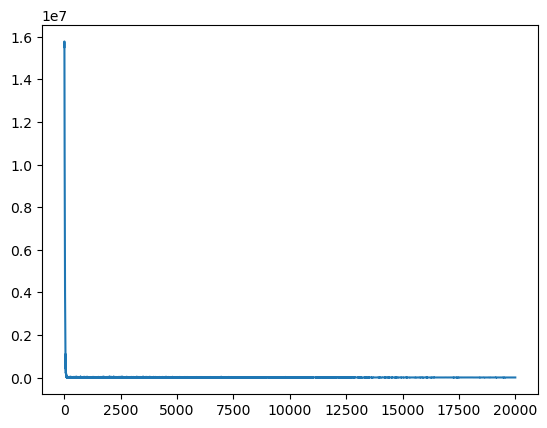

In [59]:
plt.plot(elbos)

In [60]:
#with tyxe.poutine.local_reparameterization():
m, sd = bnn.predict(x_test.to(DEVICE), num_predictions=50)
m, sd = m.detach().cpu(), sd.detach().cpu()


In [61]:
#m = bnn.predict(x_test.to(DEVICE), num_predictions=50, aggregate=False)
#m.shape

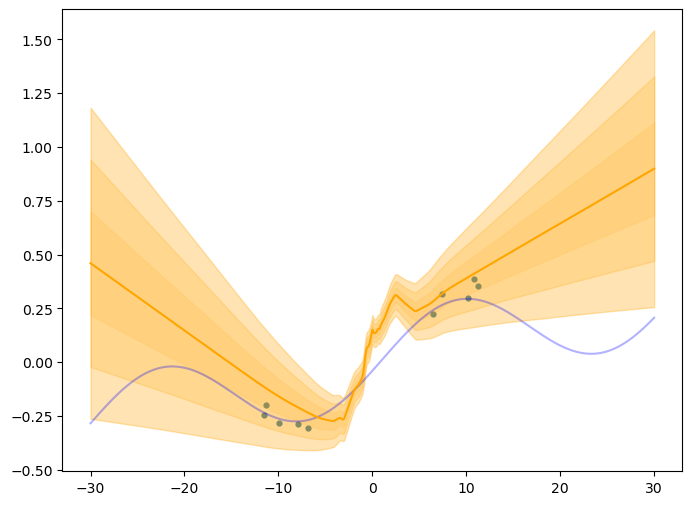

In [62]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)
plt.plot(x_test, m.detach(), color="orange")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="orange")

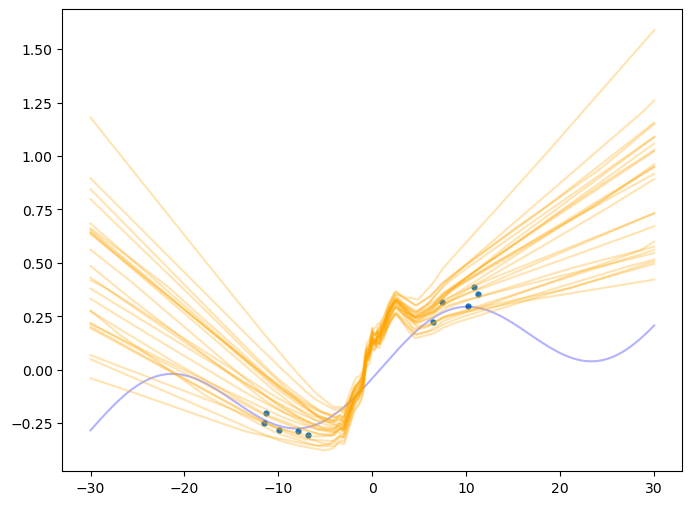

In [63]:

sampled_predictions = bnn.predict(x_test.to(DEVICE), num_predictions=25, aggregate=False).detach().cpu()

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)
for yhat in sampled_predictions:
    plt.plot(x_test, yhat, color="orange", alpha=0.3)

In [20]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=0.1)
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder)

In [21]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []
def callback(bnn, i, e):
    if i % 1000 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.local_reparameterization():
    bnn.fit(loader, optim, 20000, callback)

epoch: 0 | elbo: 13107.5556640625
epoch: 1000 | elbo: 560.4853515625
epoch: 2000 | elbo: 475.3692321777344
epoch: 3000 | elbo: 411.5968933105469
epoch: 4000 | elbo: 401.909423828125
epoch: 5000 | elbo: 312.59478759765625
epoch: 6000 | elbo: 255.52639770507812
epoch: 7000 | elbo: 212.34901428222656
epoch: 8000 | elbo: 157.47190856933594
epoch: 9000 | elbo: 124.6539306640625
epoch: 10000 | elbo: 97.60101318359375
epoch: 11000 | elbo: 67.49118041992188
epoch: 12000 | elbo: 53.03279495239258
epoch: 13000 | elbo: 50.75941467285156
epoch: 14000 | elbo: 47.11913299560547
epoch: 15000 | elbo: 48.12781524658203
epoch: 16000 | elbo: 43.87224197387695
epoch: 17000 | elbo: 45.516136169433594
epoch: 18000 | elbo: 47.74923324584961
epoch: 19000 | elbo: 43.51197052001953


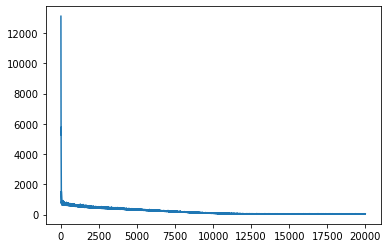

In [22]:
plt.plot(elbos)

In [23]:
m, sd = bnn.predict(x_test, num_predictions=50)
m, sd = m.detach(), sd.detach()

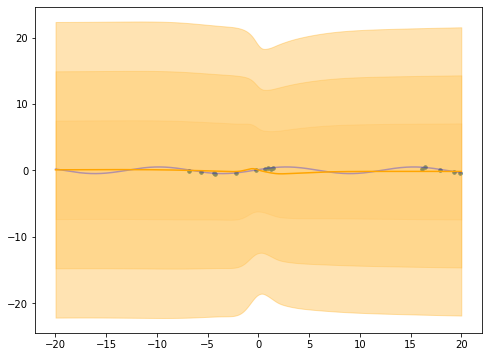

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x.squeeze(), y, s=12)
plt.plot(x_test.squeeze(), y_test, color="blue", alpha=0.3)
plt.plot(x_test, m.detach(), color="orange")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="orange")